# 1. Brief Tour of E-Cell4 Simulations

First of all, you have to load the E-Cell4 library:

In [1]:
%matplotlib inline
from ecell4 import *

## 1.1. Quick Demostration

There are three fundamental components consisting of E-Cell System version 4, which are `Model`, `World`, and `Simulator`. These components describe concepts in simulation.

* `Model` describes a problem to simulate as its name suggests.  
* `World` describes a state, e.g. an initial state and a state at a time-point.  
* `Simulator` describes a solver.

`Model` is independent from solvers. Every solver can share a single `Model` instance. Each alogrithm has a corresponding pair of `World` and `Simulator` (these pairs are capsulized into `Factory` class). `World` is not necessarily needed to be bound to `Model` and `Simulator`, but `Simulator` needs both `Model` and `World`.

Before running a simulation, you have to make a `Model`. E-Cell4 supports multiple ways to buld a `Model` (See [2. How to Build a Model](2. How to Build a Model.ipynb)). Here, we explain the simplest way using the `with` statement with `reaction_rules`:

In [2]:
with reaction_rules():
    A + B > C | 0.01  # equivalent to create_binding_reaction_rule
    C > A + B | 0.3   # equivalent to create_unbinding_reaction_rule

m1 = get_model()
print(m1)

Please remember to write parentheses `()` after `reaction_rules`. Here, a `Model` with two `ReactionRule`s named `m` was built. Lines in the `with` block describe `ReactionRule`s, a binding and unbinding reaction respectively. A kinetic rate for the mass action reaction is defined after a separator `|`, i.e. `0.01` or `0.3`. In the form of ordinary differential equations, this model can be described as:

$$[\mathrm{A}]'=[\mathrm{B}]'=-[\mathrm{C}]=-0.01[\mathrm{A}][\mathrm{B}]+0.3[\mathrm{C}]$$

For more compact description, `A + B == C | (0.01, 0.3)` is also acceptable.

E-Cell4 has a simple interface to run simulations with the given model, `run_simulation`. This enables for you to run simulations without instanciate `World` and `Simulator` by yourself. To solve this model, you have to give a volume, an initial value for each `Species` and duration of time:

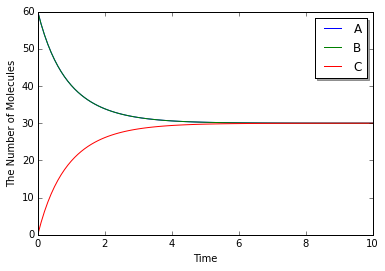

In [3]:
run_simulation(10.0, model=m1, y0={'A': 60, 'B': 60}, volume=1.0)

To switch simulation algorithm, you only need to give the type of solver (`ode` is used as a default) as follows:

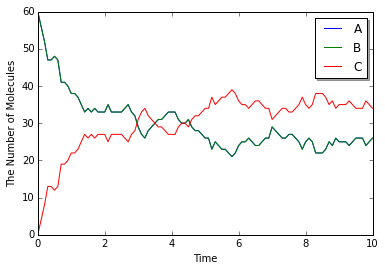

In [4]:
run_simulation(10.0, model=m1, y0={'A': 60, 'B': 60}, solver='gillespie')

## 1.2. Spatial Simulation and Visualization

E-Cell4 now supports multiple spatial algorithms, `egfrd`, `spatiocyte` and `meso`. In addition to the model used in non-spatial solvers (`ode` and `gillespie`), these spatial solvers need extra information about each `Species`, i.e. a diffusion coefficient and radius.

The `with` statement with `species_attributes` is available to describe these properties:

In [5]:
with species_attributes():
    A | B | C | {'radius': '0.005', 'D': '1'}  # 'D' is for the diffusion coefficient

with reaction_rules():
    A + B == C | (0.01, 0.3)

m2 = get_model()

Even though the properties indicate a floating number, each attribute must be given as a string.

Now you can run a spatial simulation in the same way as above (`egfrd` would need long time to simulate):

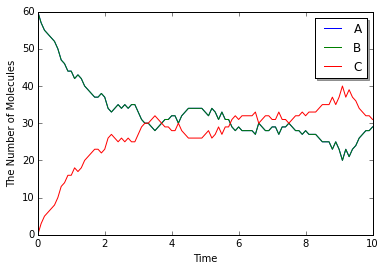

In [6]:
run_simulation(10.0, model=m2, y0={'A': 60, 'B': 60}, solver='meso')

Structure (e.g. membrane, cytoplasm and nucleus) is only supported by `spatiocyte` and `meso` now. For the simulation, `location` that each species belongs to must be specified in its attribute first.

In [7]:
with species_attributes():
    A | {'D': '1', 'location': 'S'}  # 'S' is a name of the structure

m3 = get_model()  # with no reactions

E-Cell4 supports primitive shapes as a structure like `Sphere`:

In [8]:
sphere = Sphere(Real3(0.5, 0.5, 0.5), 0.48)  # a center position and radius

E-Cell4 provides various kinds of `Observer`s, which log the state during a simulation. Two observers are declared to log positions of molecules. `FixedIntervalTrajectoryObserver` logs a trajectory of a molecule, and `FixedIntervalHDF5Observer` saves `World` to a HDF5 file at the given interval:

In [9]:
obs1 = FixedIntervalTrajectoryObserver(1e-3)
obs2 = FixedIntervalHDF5Observer(0.1, 'data/test%02d.h5')

Then, `run_simulation` accepts structures and observers as arguments `structure` and `observers` respectively (see also `help(run_simulation)`):

In [10]:
run_simulation(1.0, model=m3, y0={'A': 60}, structures={'S': sphere},
               solver='spatiocyte', observers=(obs1, obs2), return_type=None)

E-Cell4 also provides visualizations including an interactive visualization on IPython Notebook like `viz.plot_world`. `viz.plot_world` plots positions of molecules in 3D. In addition, by using `load_world`, you can easily restore the state of `World` from a HDF5 file:

In [11]:
viz.plot_world(load_world('data/test00.h5'), species_list=['A'])

Also for `FixedIntervalTrajectoryObserver`, `viz.plot_trajectory` plots trajectories in the interactive way:

In [12]:
viz.plot_trajectory(obs1)

For more details, see [X. How to Log and Visualize Simulations]().